In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

### List of specific speech URLs

In [3]:
speech_urls = [
    'https://www.presidency.ucsb.edu/documents/inaugural-address-53',
    'https://www.presidency.ucsb.edu/documents/inaugural-address-14',
    'https://www.presidency.ucsb.edu/documents/inaugural-address-15',
    'https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-28',
    'https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-17',
    'https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union'
]

### Here I created a function to get the title, date, and contenth for each presidential speech provided.

In [4]:
def scrape_speech(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Extract title
    title = soup.find('h1').text if soup.find('h1') else 'No Title'
    
    date_div = soup.find('div', {'class': 'field-docs-start-date-time'})
    date = date_div.find('span').get('content') if date_div else 'No Date'
    
    # Extract content
    content_div = soup.find('div', {'class': 'field-docs-content'})
    content = content_div.text.strip() if content_div else 'No Content'
    
    return title, date, content

### For every url provided, I will call the scrape fucntion and store the title, data, and content in an array to then turn it into a data frame.

In [5]:
speeches = []
for url in speech_urls:
    try:
        title, date, content = scrape_speech(url)
        speeches.append({'title': title, 'date': date, 'content': content})
    except Exception as e:
        print(f"Failed to scrape {url}: {e}")

df = pd.DataFrame(speeches)
df.to_csv('presidential_speeches.csv', index=False)

print("Data collection complete. Saved to presidential_speeches.csv")

Data collection complete. Saved to presidential_speeches.csv


### This part of the code initializes two key components for text preprocessing:
- `stop_words`: A set of common English words (like "and", "the", "is") that are often removed from text data because they do not contribute much to the meaning.
- `lemmatizer`: An instance of the `WordNetLemmatizer` class, which is used to reduce words to their base or root form (e.g., "running" becomes "run"). This helps in standardizing the words in the text data.

In [15]:
df = pd.read_csv('presidential_speeches.csv')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [7]:
def preprocess_text(text):
    # Tokenize the text
    words = word_tokenize(text.lower())
    # Remove stop words and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word.isalpha() and word not in stop_words]
    return ' '.join(words)


### This part of the code processes the text of each speech and saves the cleaned data to a new CSV file:
- The `preprocess_text` function is applied to each speech in the 'content' column, and the results are stored in a new column called 'processed_content'.
- The DataFrame, now including the cleaned text, is saved to a CSV file named 'processed_presidential_speeches.csv'.
- A message is printed to confirm that the preprocessing is complete and the data is saved.

In [8]:
# Apply preprocessing to the content column
df['processed_content'] = df['content'].apply(preprocess_text)

df.to_csv('processed_presidential_speeches.csv', index=False)

print("Text preprocessing complete. Saved to processed_presidential_speeches.csv")

Text preprocessing complete. Saved to processed_presidential_speeches.csv


### This section sets up the VADER sentiment intensity analyzer, which will be used to analyze the sentiment of the preprocessed text. The function `get_sentiment` is defined to calculate the sentiment scores for a given text.

In [9]:
df = pd.read_csv('processed_presidential_speeches.csv')

sia = SentimentIntensityAnalyzer()

# Function to get sentiment scores
def get_sentiment(text):
    return sia.polarity_scores(text)

### This code chunk applies the sentiment analysis function to the processed content of each speech. The sentiment scores (positive, negative, neutral, and compound) are calculated and stored in a new DataFrame.

In [10]:
# Apply sentiment analysis to the processed content
df['sentiment'] = df['processed_content'].apply(get_sentiment)

# Expand sentiment dictionary into separate columns
sentiment_df = df['sentiment'].apply(pd.Series)

# Concatenate the sentiment columns to the original dataframe
df = pd.concat([df, sentiment_df], axis=1)

# Save the dataframe with sentiment scores
df.to_csv('presidential_speeches_with_sentiment.csv', index=False)

print("Sentiment analysis complete. Saved to presidential_speeches_with_sentiment.csv")

Sentiment analysis complete. Saved to presidential_speeches_with_sentiment.csv


In [11]:
for index, row in df.iterrows():
    sentiment_scores = sia.polarity_scores(row['processed_content'])
    df.at[index, 'sentiment'] = sentiment_scores
    print(f"Title: {row['title']}")
    print(f"Date: {row['date']}")
    print(f"Sentiment Scores: {sentiment_scores}")
    print("-" * 80)

Title: Inaugural Address
Date: 2021-01-20T11:52:00+00:00
Sentiment Scores: {'neg': 0.159, 'neu': 0.563, 'pos': 0.278, 'compound': 0.9994}
--------------------------------------------------------------------------------
Title: Inaugural Address
Date: 2017-01-20T12:04:00+00:00
Sentiment Scores: {'neg': 0.095, 'neu': 0.578, 'pos': 0.326, 'compound': 0.9997}
--------------------------------------------------------------------------------
Title: Inaugural Address
Date: 2013-01-21T11:55:00+00:00
Sentiment Scores: {'neg': 0.138, 'neu': 0.581, 'pos': 0.282, 'compound': 0.9995}
--------------------------------------------------------------------------------
Title: Address Before a Joint Session of the Congress on the State of the Union
Date: 2022-03-01T21:08:00+00:00
Sentiment Scores: {'neg': 0.131, 'neu': 0.643, 'pos': 0.226, 'compound': 0.9999}
--------------------------------------------------------------------------------
Title: Address Before a Joint Session of the Congress on the State of

### Visualizations

In [12]:
df = pd.read_csv('presidential_speeches_with_sentiment.csv')

df['url'] = speech_urls

# Map the URLs to president names
url_to_president = {
    'https://www.presidency.ucsb.edu/documents/inaugural-address-53': 'Joe Biden',
    'https://www.presidency.ucsb.edu/documents/inaugural-address-14': 'Donald Trump',
    'https://www.presidency.ucsb.edu/documents/inaugural-address-15': 'Barack Obama',
    'https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-28': 'Joe Biden',
    'https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-17': 'Barack Obama',
    'https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union': 'George W. Bush'
}

df['president'] = df['url'].map(url_to_president)


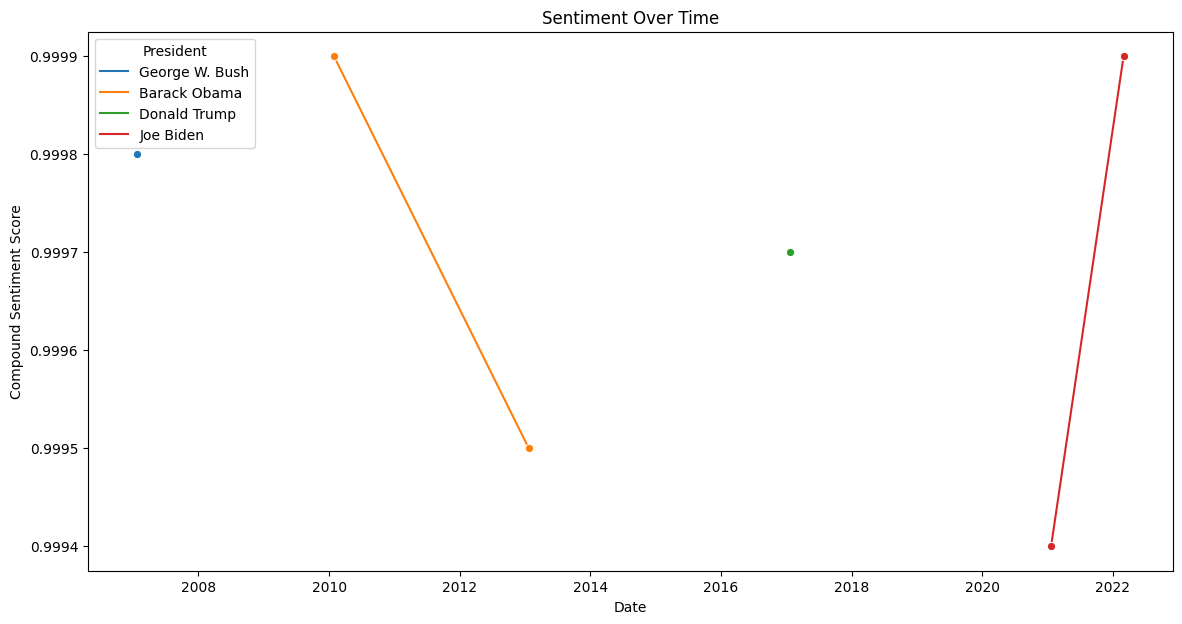

In [13]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%dT%H:%M:%S%z', errors='coerce')

# Sort dataframe by date
df = df.sort_values(by='date')

plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x='date', y='compound', hue='president', marker='o')
plt.title('Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Compound Sentiment Score')
plt.legend(title='President')
plt.show()

#### Interpretation:
This line plot visualizes the compound sentiment scores of presidential speeches over time for Barack Obama and Joe Biden. Each line represents the sentiment trajectory during their respective terms.

- **Barack Obama**: The sentiment data for Obama shows a balanced sentiment throughout his presidency. His speeches often balanced optimism with realism, reflecting his focus on recovery from the financial crisis and pushing forward with healthcare reform. The steady sentiment scores indicate his consistent rhetorical approach to address both achievements and ongoing challenges.

- **Joe Biden**: The data for Biden, although limited to the early years of his term, shows a high positive sentiment, likely reflecting his efforts to unite the country and address ongoing issues like the COVID-19 pandemic and economic recovery. His speeches emphasize steady and reassuring communication, aimed at maintaining public confidence during these times.

These insights highlight the different rhetorical strategies employed by Obama and Biden in response to their unique political landscapes, providing a clearer understanding of their communication styles and priorities during their presidencies.

In [14]:
import plotly.graph_objects as go
import plotly.express as px

# Calculate average sentiment scores by president
average_sentiments = df.groupby('president')[['pos', 'neg', 'neu', 'compound']].mean().reset_index()

melted_avg_sentiments = average_sentiments.melt(id_vars='president', var_name='Sentiment', value_name='Score')

fig = px.bar(
    melted_avg_sentiments,
    x='president',
    y='Score',
    color='Sentiment',
    barmode='group',
    title='Average Sentiment Scores by President',
    labels={'Score': 'Average Score', 'president': 'President'}
)

fig.show()

        president    pos     neg     neu  compound
0    Barack Obama  0.262  0.1425  0.5955   0.99970
1    Donald Trump  0.326  0.0950  0.5780   0.99970
2  George W. Bush  0.264  0.1710  0.5650   0.99980
3       Joe Biden  0.252  0.1450  0.6030   0.99965


#### Interpretation:
This bar chart compares the average sentiment scores (positive, negative, and compound) for each president. By analyzing these scores, we can infer the overall emotional tone of each president's speeches.

- **Barack Obama**: Exhibits a balanced emotional tone with moderate positive and negative sentiment scores. This suggests a measured approach in addressing both challenges and achievements.
- **Donald Trump**: Shows the highest average positive sentiment among the presidents analyzed, indicating a more optimistic and perhaps assertive rhetorical style.
- **George W. Bush**: Has the highest average negative sentiment score, reflecting the turbulent times of his presidency, such as post-9/11 events and the Iraq War.
- **Joe Biden**: Displays the highest average neutral sentiment, suggesting a focus on informative and steady communication, possibly to maintain public confidence during ongoing crises like the COVID-19 pandemic.

These interpretations highlight how each president's rhetoric aligns with their political context and the challenges they faced, providing insights into their communication strategies and the overall emotional tone of their public addresses.